# Task 2: Data Analysis

This project involves collecting song and artist data from the Genius open web API for four different artists:
- Elton John
- Hozier
- Kanye West
- Kendrick Lamar

This notebook covers <b>Task 2 - Data Preparation and Analysis</b>.

We will use all of the JSON data collected during Task 1 to perform the analysis process.

# Data Preprocessing

In [54]:
import json
import numpy as np
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

Establishing settings for data analysis and visulaisation.

In [55]:
# The artists that we would like to study
artist_names = ['Kendrick Lamar', 'Kanye West','Elton John','Hozier']
# Precision that we'll use for Pandas display
pd.set_option('display.precision', 2)
# Colors that we will use in various plots
artist_colours = {'Kendrick Lamar':"green", 'Kanye West':"darkred", 'Elton John':"orange", 'Hozier':"navy"}
# Default font size
fontsize = 13

Establishing data storage directories.

In [56]:
# directory for raw data storage
dir_raw = Path("raw")
dir_lyrics = Path("lyrics")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)
# Sections of the lists in the files where different collected data is stored
search_data = 0
artist_data = 1

Finding all the raw JSON files and separate by artist.

In [57]:
artist_files = {}
for artist_name in artist_names:
    artist_files[artist_name] = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == '.json':
        # Parse the filename
        parts = fpath.stem.split("-")
        if parts[0] in artist_names:
            artist_files[parts[0]].append(fpath)

for artist_name in artist_names:
    print('%s: Found %d raw data files' % (artist_name, len(artist_files[artist_name])))
    

Kendrick Lamar: Found 11 raw data files
Kanye West: Found 11 raw data files
Elton John: Found 11 raw data files
Hozier: Found 11 raw data files


## Data Parsing and Merging
 Parse the individula raw JSON files from Genius
 

In [58]:
def round_datetime(obs_date):
    # Round and convert to a Pandas TimeStamp
    ts = pd.Timestamp(obs_date)
    time = ts.round(freq="min")
    return time


In [59]:
def parse_raw_data(fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    # Find the date and time in the file name 
    parts = fpath.stem.split("-")
    time = round_datetime(parts[1]+parts[2])

    rows = []
    for obs in data[search_data]['response']['hits']:
        row = {"Artist": parts[0], "Followers": data[artist_data]['response']['artist']['followers_count']}
        # Add date 
        row["Date"] = time
        # Add title
        row['Song Title'] = obs['result']['title']
        # Add song ID
        row['ID'] = obs['result']['id']
        # Add number of annotations on song
        row['Annotations'] = obs['result']['annotation_count']
        # Add number of Pyongs (song shares)
        row['User Interest'] = obs['result']['pyongs_count']
        # Add number of page views
        row['Page Views'] = obs['result']['stats']['pageviews']
        rows.append(row)
    fin.close()
    
    return pd.DataFrame(rows).set_index('Artist')
    

In [60]:
#Test the fuction
for fpath in dir_raw.iterdir():
    if fpath.suffix == '.json':
        times = parse_raw_data(fpath)
times

,Followers,Date,Song Title,ID,Annotations,User Interest,Page Views
Artist,,,,,,,
Kendrick Lamar,29378,2024-07-23 19:49:00,HUMBLE.,3039923,20,1204,11751898
Kendrick Lamar,29378,2024-07-23 19:49:00,​euphoria,10341021,89,140,9634348
Kendrick Lamar,29378,2024-07-23 19:49:00,Not Like Us,10359264,61,144,8725135
Kendrick Lamar,29378,2024-07-23 19:49:00,​m.A.A.d city,90478,82,2239,7449028
Kendrick Lamar,29378,2024-07-23 19:49:00,Swimming Pools (Drank),81159,48,986,6659169
Kendrick Lamar,29378,2024-07-23 19:49:00,DNA.,3035222,38,693,6350122
Kendrick Lamar,29378,2024-07-23 19:49:00,Money Trees,90475,54,994,6420582
Kendrick Lamar,29378,2024-07-23 19:49:00,XXX.,3047142,26,245,5806412
Kendrick Lamar,29378,2024-07-23 19:49:00,"Bitch, Don’t Kill My Vibe",90473,36,705,5201090


Function to parse and merge a collection of raw data

In [61]:
def parse_merge_raw_data(artist_name, fpaths):
    df_files = []
    # Process each file for the artist
    print("Reading and parsing %d JSON data files ..." %len(fpaths))
    for fpath in fpaths:
        #produce a DataFrame form this file 
        df_file = parse_raw_data(fpath)
        df_files.append(df_file)
    # concatenate all the DataFrames together into a single frame
    df_artist = pd.concat(df_files)
    # Set the index column to be the Date, which is now unique
    df_artist.set_index("Date", inplace=True)
    # Sort the frame by its index
    return df_artist.sort_index()


Parse and merge the raw data files for each city, producing a single merged Pandas Data Frames for each city which we can analyse later on:

In [62]:
df_artists = {}
for artist_name in artist_names:
    print("-- %s" % artist_name)
    df_artist = parse_merge_raw_data(artist_name, artist_files[artist_name]) 
    df_artists[artist_name] = df_artist
    

-- Kendrick Lamar
Reading and parsing 11 JSON data files ...
-- Kanye West
Reading and parsing 11 JSON data files ...
-- Elton John
Reading and parsing 11 JSON data files ...
-- Hozier
Reading and parsing 11 JSON data files ...


Create a function to read and count the approximate number of lyrics of each song, stored in text files, obtained from the API data 'path'.

In [63]:
def lyrics_count(fpath):
    fin = open(fpath, "r")
    data  = fin.read()
    lyrics = json.loads(data)
    count = len(lyrics.split())
    
    return count

Find the approximate number of lyrics in each song and store in a dictionary for each artist.

In [64]:
num_lyrics_artist = {}
for artist_name in artist_names:
    num_lyrics_song = {}
    for fpath in dir_lyrics.iterdir():
        if fpath.suffix == '.txt':
            parts = fpath.stem.split("-")
            if parts[1] == artist_name:
                num_lyrics_song[parts[0]] = lyrics_count(fpath)
    num_lyrics_artist[artist_name] = num_lyrics_song

Add the number of lyrics per song to the artist Data Frame.

In [65]:
for artist_name in artist_names:
    number_of_lyrics = []
    for song in df_artists[artist_name]["Song Title"]:
        if song in num_lyrics_artist[artist_name]:
            number_of_lyrics.append(num_lyrics_artist[artist_name][song])
        else:
            number_of_lyrics.append(np.nan)  # or use another placeholder like 0 or '' if appropriate

    df_artists[artist_name] = df_artists[artist_name].assign(Lyrics = number_of_lyrics)

## Data Verification
Check the format of the new data

In [66]:
df_artists["Kanye West"].head(10)

,Followers,Song Title,ID,Annotations,User Interest,Page Views,Lyrics
Date,,,,,,,
2022-03-17 11:40:00,13428,Mercy,70324,64,365,6942058,0
2022-03-17 11:40:00,13428,Niggas in Paris,51899,35,443,6239156,0
2022-03-17 11:40:00,13428,"Father Stretch My Hands, Pt. 1",2412669,14,284,4687283,348
2022-03-17 11:40:00,13428,Monster,1149,60,409,4661000,0
2022-03-17 11:40:00,13428,Ultralight Beam,2413549,39,360,4308415,0
2022-03-17 11:40:00,13428,Bound 2,158615,39,420,4008290,0
2022-03-17 11:40:00,13428,Clique,87225,46,189,3721379,0
2022-03-17 11:40:00,13428,I Love It,3944360,13,202,3471233,0
2022-03-17 11:40:00,13428,No Church in the Wild,52020,29,237,3238346,0


Check number of rows and date ranges in the DataFrames

In [67]:
def summarize_dates():
    rows = []
    for artist_name in artist_names:
        row = {"Artist": artist_name}
        row["Rows"] = len(df_artists[artist_name])
        row["DateStart"] = df_artists[artist_name].index.min()
        row["DateEnd"] = df_artists[artist_name].index.max()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Artist")

#Display the ranges
df_date_summary = summarize_dates()
df_date_summary

,Rows,DateStart,DateEnd
Artist,,,
Kendrick Lamar,110,2022-03-17 11:40:00,2024-07-23 19:49:00
Kanye West,110,2022-03-17 11:40:00,2024-07-23 19:49:00
Elton John,110,2022-03-17 11:40:00,2024-07-23 19:49:00
Hozier,110,2022-03-17 11:40:00,2024-07-23 19:49:00


Check for missing values in DataFrames

In [68]:
for artist_name in artist_names:
    print("-- %s" % artist_name)
    missing_counts = df_artists[artist_name].isnull().sum()
    # Which columns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)
        

-- Kendrick Lamar
No missing values found
-- Kanye West
No missing values found
-- Elton John
No missing values found
-- Hozier
Lyrics    10
dtype: int64


## Data Saving

Now write out all of the merged artist DataFrames in JSON format, one file per city. These will represent the 'clean' data that we will use next for our actual data analysis:

In [69]:
for artist_name in artist_names:
    fname = "%s.json" % artist_name
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_artists[artist_name].to_json(out_path, orient="table", indent=4)

Writing data\Kendrick Lamar.json
Writing data\Kanye West.json
Writing data\Elton John.json
Writing data\Hozier.json


# Data Analysis

## Annotation Analysis

First we will look at Annotation data.

Create a function to look at the raw statistics of each artist so that it may be reused later.

In [70]:
def compute_stats(col_name):
    rows = []
    for artist_name in artist_names:
        row = {"Artist": artist_name}
        row["Min"] = df_artists[artist_name][col_name].min()
        row["Max"] = df_artists[artist_name][col_name].max()
        row["Mean"] = df_artists[artist_name][col_name].mean()
        row["Median"] = df_artists[artist_name][col_name].median()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Artist")

In [71]:
df_annotation_stats = compute_stats("Annotations")
df_annotation_stats

,Min,Max,Mean,Median
Artist,,,,
Kendrick Lamar,18,89,38.72,37.0
Kanye West,13,65,39.27,39.0
Elton John,2,15,8.27,9.5
Hozier,10,29,17.40,17.0


Find the number of annotations for each of the artist's ten songs returned by the Genius search capability.

In [72]:
df_annotations_per_song = {}
for artist_name in artist_names:
    # Group each index by song
    groups = df_artists[artist_name]["Annotations"].groupby(df_artists[artist_name]["Song Title"])
    annotations = groups.mean()

    df_annotations_per_song[artist_name] = pd.DataFrame({"Annotations": annotations})
    

Plot the number of annotations per song on a bar chart for each artist.

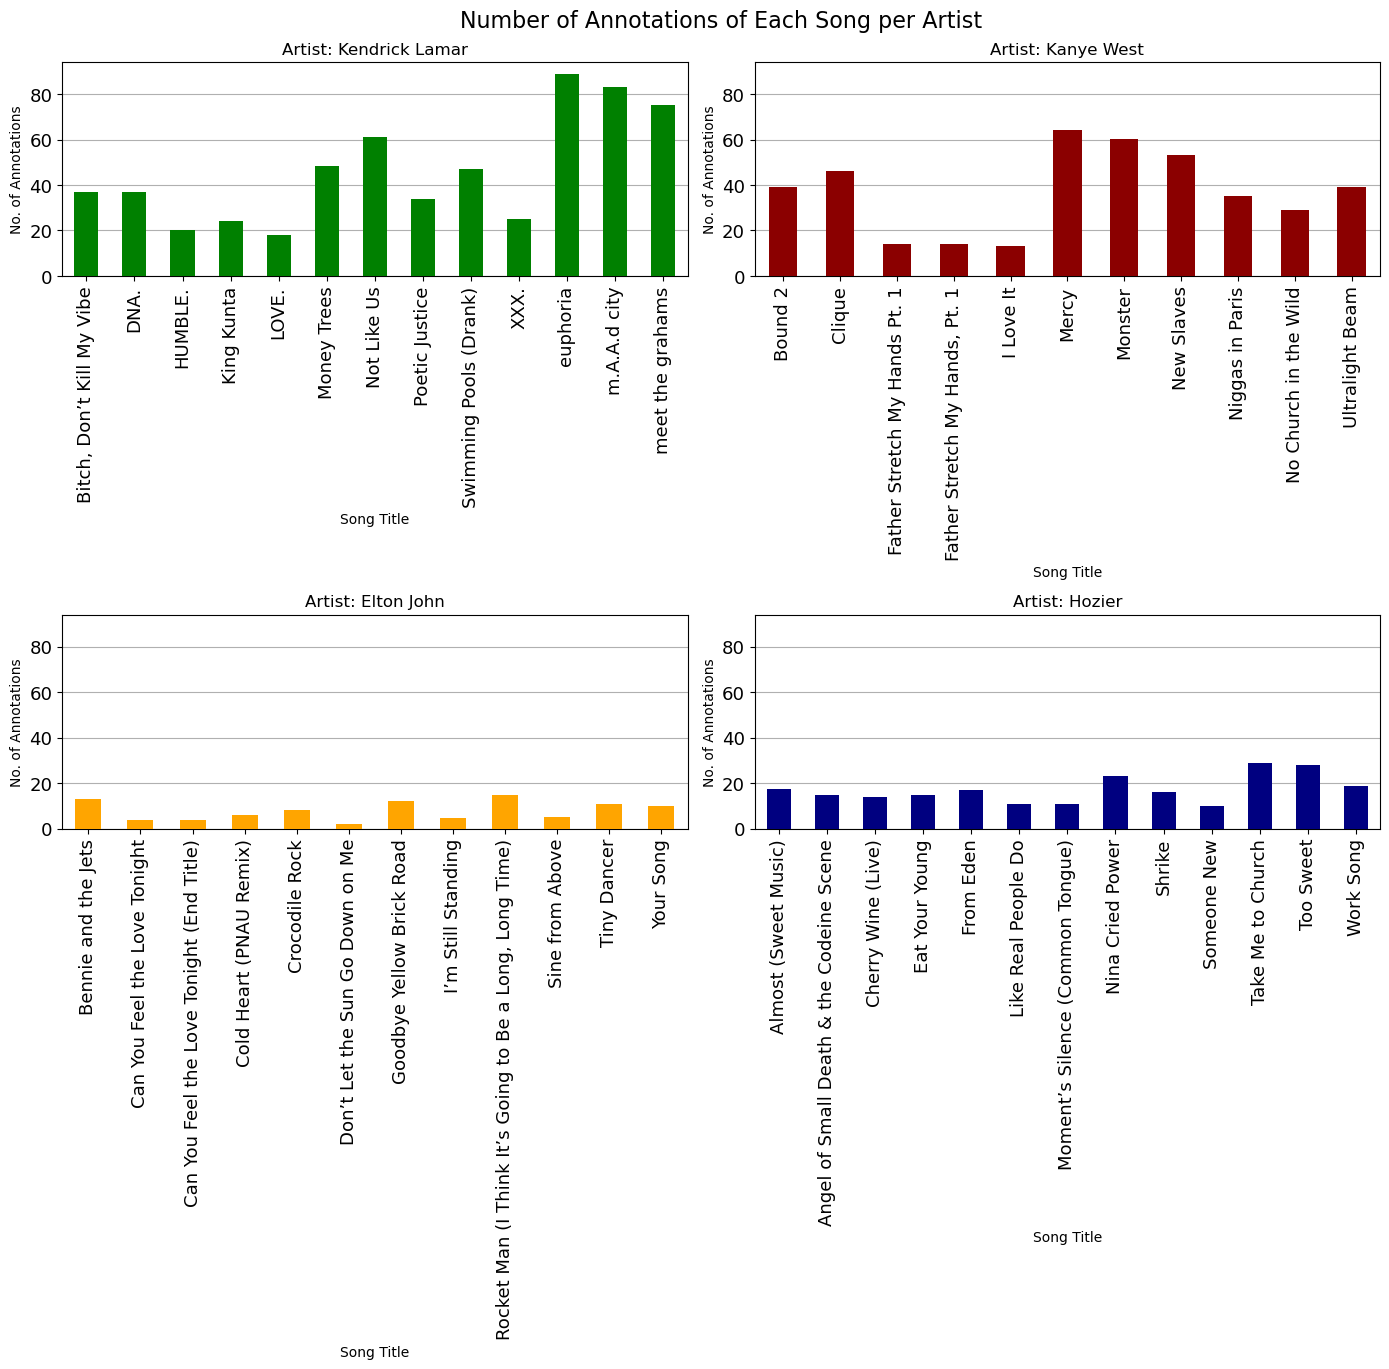

In [74]:
fig = plt.figure(figsize=(14,14))
plt.title("Number of Annotations of Each Song per Artist\n", fontsize=fontsize+3)
plt.axis("Off")
for i, artist_name in enumerate(artist_names):
    axc = fig.add_subplot(2, 2, i+1)
    ax = df_annotations_per_song[artist_name].plot.bar(ax=axc, 
        color=artist_colours[artist_name], fontsize=fontsize, zorder=3)

    ax.set_title("Artist: %s" % artist_name)
    ax.set_ylabel("No. of Annotations")

    # Make the y-axis ranges consistent for comaprison
    ax.set_ylim(0, df_annotation_stats["Max"].max()+5)
    ax.yaxis.grid(True);   
    ax.get_legend().remove()
# fix the spacing between plots
fig.tight_layout()


The number of annotations for different songs and artist's can be seen in the graphs above.

The number of annotations for each song is clear.

In some cases there are large differences in the number of annotations an artist recieves for a song, <b>for example</b> Kendrick Lamar and Kanye West have a large range of annotations differing per song, while other artist's have a consistant number.

Plotting the Max and Min of each artist on the same graph, giving us a visulaisation of the difference in user interaction for different artists.

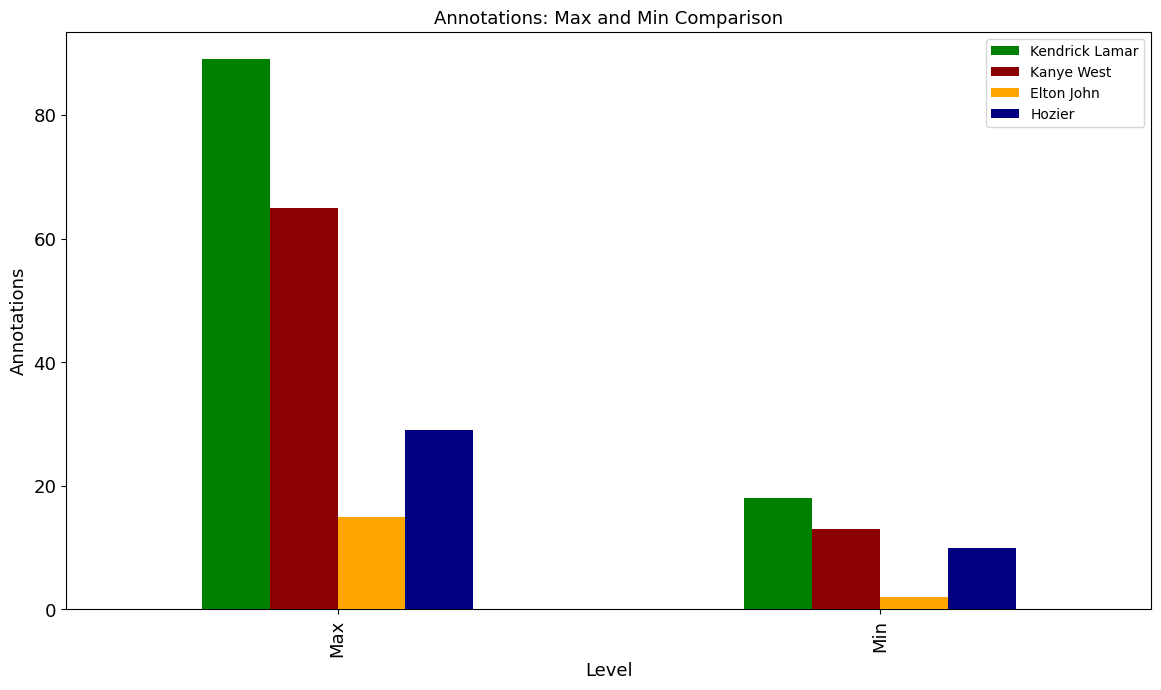

In [76]:
# Combine the max and min values into a new DataFrame
df_annotation_max_min = {}
i = 0
df_max_min = {}
for artist_name in artist_names:
    df_max_min[artist_name] = {"Max":df_annotation_stats.iloc[i]["Max"]  , "Min":df_annotation_stats.iloc[i]["Min"]}
    i = i+1
    
df_max_min = pd.DataFrame(df_max_min)
ax = df_max_min.plot.bar(figsize=(14,7.5), color = artist_colours, fontsize=fontsize, zorder = 3)

ax.set_title("Annotations: Max and Min Comparison", fontsize=fontsize)
ax.set_xlabel("Level", fontsize=fontsize)
ax.set_ylabel("Annotations", fontsize=fontsize);

This graph helps further visualise the difference in number of annotations per artist. Evidently certain artist's songs recieve far more annotation interest than others. It also displays the fact that some songs don't have many annotations, even if the artist in general recieves more annotations per song.

Creating a boxplot to examine the distribution of values for annotations for each artist

Text(0.5, 1.0, 'Distribution of Annotation Values')

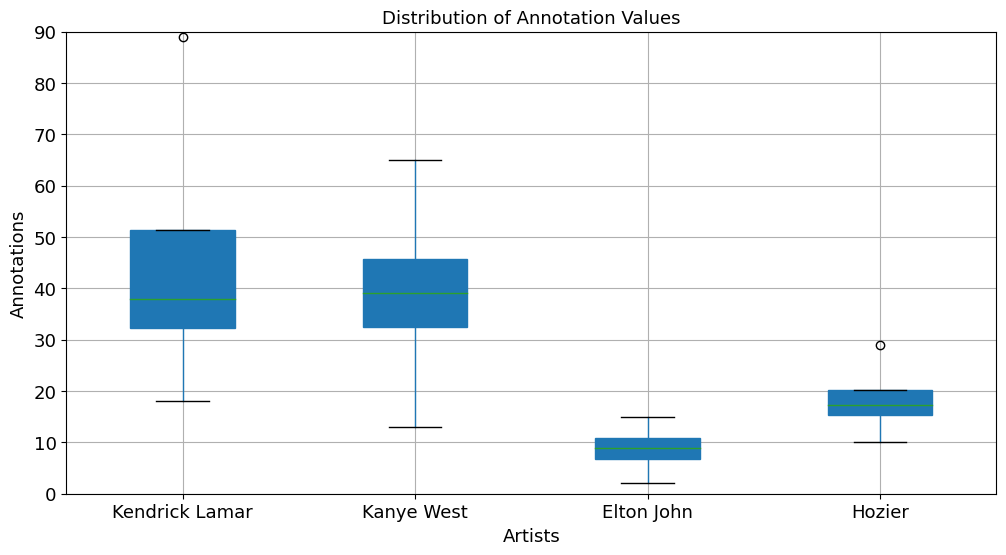

In [79]:
ax = df_annotation_stats.transpose().boxplot(figsize=(12,6), fontsize=fontsize, patch_artist=True)

# Set the colors for the boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(df_annotation_stats.columns)))

# Loop through each box and set the facecolor
for box, color in zip(ax.artists, colors):
    box.set_facecolor(color)

# Adjust the y-axis limit and labels
ax.set_ylim(0, df_annotation_stats["Max"].max() + 1)
ax.set_ylabel("Annotations", fontsize=fontsize)
ax.set_xlabel("Artists", fontsize=fontsize)
ax.set_title("Distribution of Annotation Values", fontsize=fontsize)

The boxplot shows the median values and also provides a clear view of the variation in the annotations for each artist.

For instance, we see one outlier for each artist, indicating particularly high or low annotations which are well above the median for that artist.

We can view all the annotation stats on one graph in an effort to see the full picture.

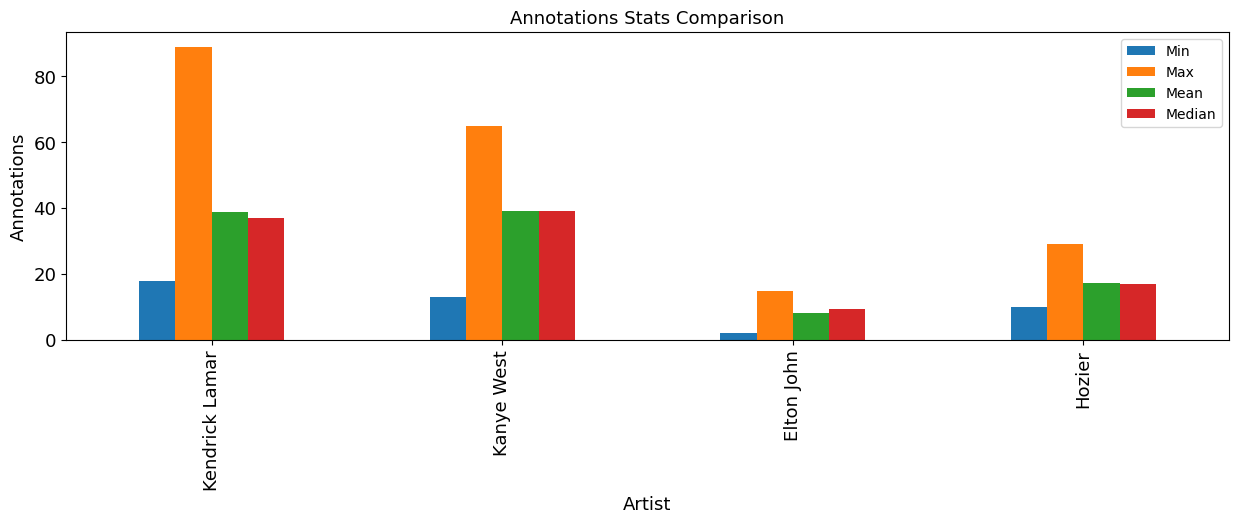

In [81]:
ax = df_annotation_stats.plot.bar(figsize=(15, 4), fontsize=fontsize)

ax.set_title("Annotations Stats Comparison", fontsize=fontsize)
ax.set_xlabel("Artist", fontsize=fontsize)
ax.set_ylabel("Annotations", fontsize=fontsize);

Finally, this plot gives a visualisation of the summary of the annotation stats per artist, displaying that some artists have major outliers (Kendrick), while other's are more consistent (Hozier).

## Page Views Analysis

Get the number of songs found in the first data collection (Genius returns 10 songs for each artist)

In [82]:
first_call = df_artist.index.min()
first_ten_songs = 0
for i in range(len(df_artist.index)):
    if df_artist.index[i] == first_call:
        first_ten_songs = first_ten_songs + 1

Finding each artists top viewed song and plotting the number of page views over the time the data was collected for each artist's most viewed songs.

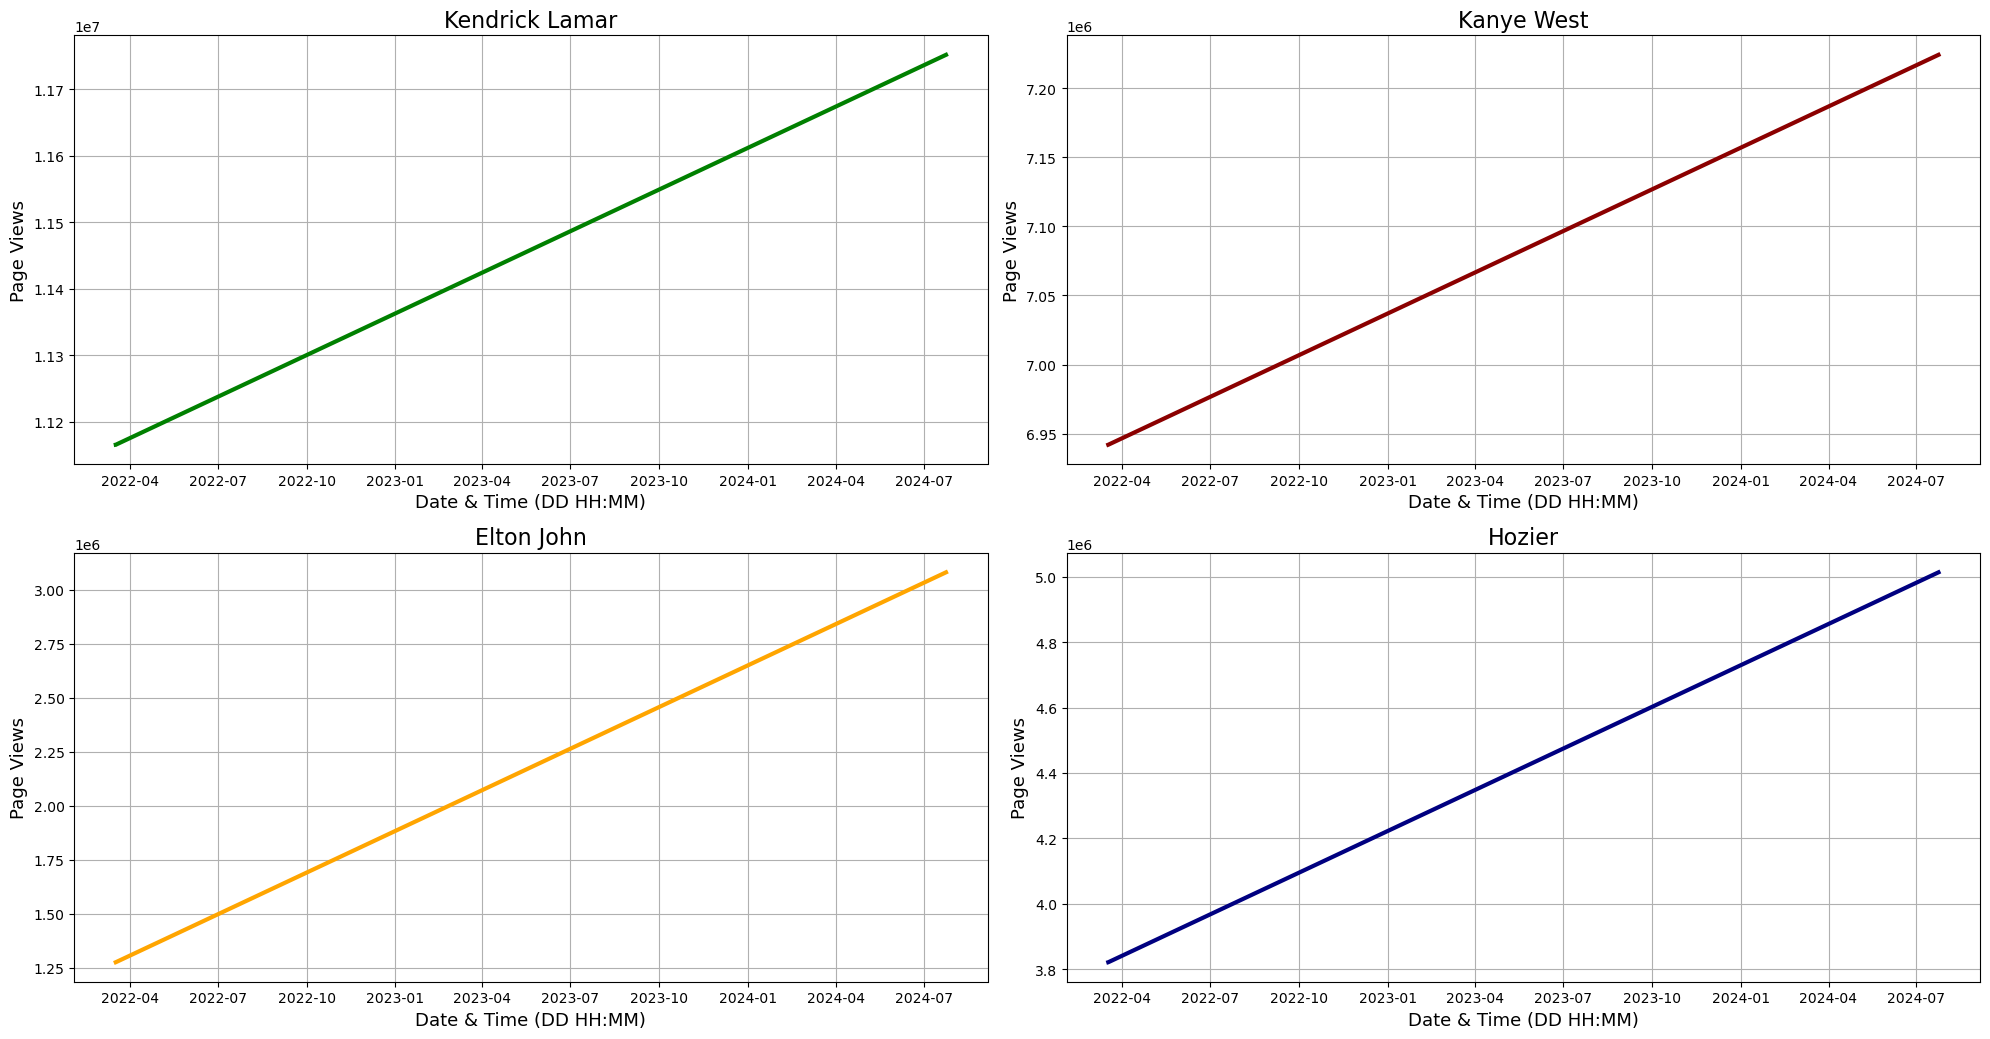

In [84]:
song_names = {}
page_views = [None]*len(artist_files[artist_name])
fig = plt.figure(figsize=(20,10.5))
# List the seperate times data is obtained at
times = list(dict.fromkeys(df_artists[artist_name]["Song Title"].index))

for i,artist_name in enumerate(artist_names):
    ax = fig.add_subplot(2, 2, i+1)
    most_views = 0
    x = 0
    #Find the top songs for each artist
    for i in range(first_ten_songs):
        info = df_artists[artist_name].iloc[i]
        if getattr(info,'Page Views') > most_views:
            most_views = getattr(info,'Page Views')
            song_names[artist_name] = getattr(info,'Song Title')

    #Find and plot the page views for the top song
    for i in range(len(df_artists[artist_name]["Song Title"])):
        if df_artists[artist_name]["Song Title"][i] == song_names[artist_name]:
            page_views[x] = df_artists[artist_name]["Page Views"][i]
            x = x+1
        
    ax.plot(times,page_views, color = artist_colours[artist_name], linewidth=3)
    
    ax.set_title("%s" % artist_name, fontsize=fontsize+3)
    ax.set_xlabel("Date & Time (DD HH:MM)", fontsize=fontsize)
    ax.set_ylabel("Page Views", fontsize=fontsize)
    ax.grid(True); 
    
    
fig.tight_layout()


From these plots, trends of Page Views can be seen over the course of an hour and a half. While each trends upwards, some have a faster rate of increase than others. Note the difference in total scale of the y-axis, this indicates that some songs have far larger overall views.

Plot the total number of pageviews over the given period per artist's top song on the same plot.


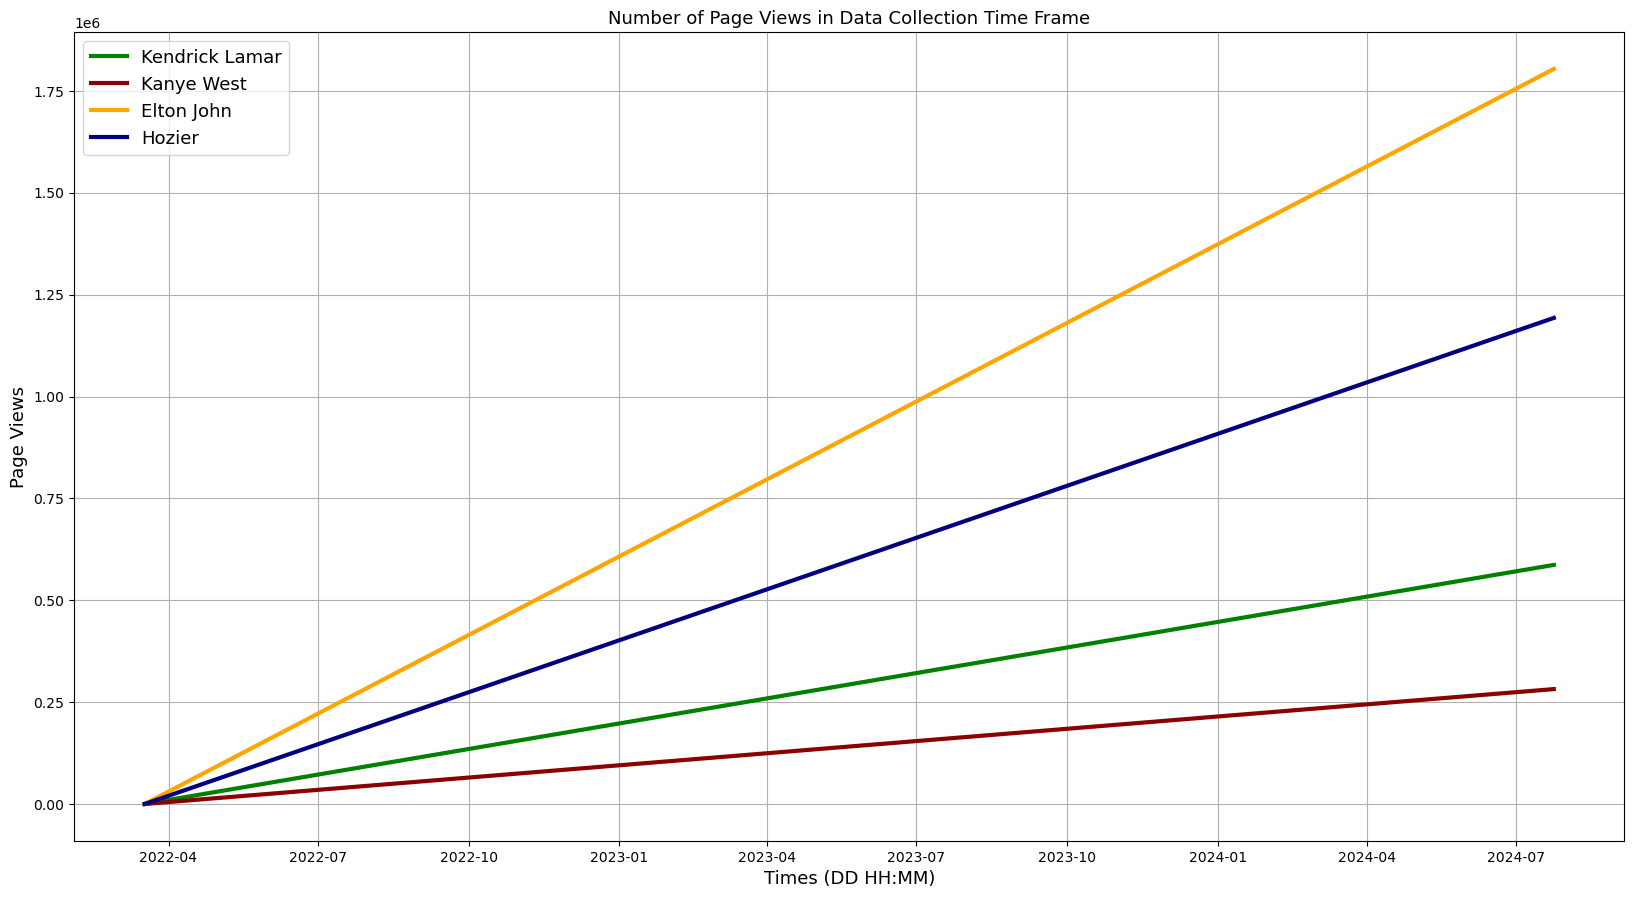

In [85]:
plt.figure(figsize=(20,10.5))
page_views = [None]*len(artist_files[artist_name])
# List the seperate times
times = list(dict.fromkeys(df_artists[artist_name]["Song Title"].index))

for i,artist_name in enumerate(artist_names):
    most_views = 0
    x = 0

    #Find and plot the page views for the top song
    for i in range(len(df_artists[artist_name]["Song Title"])):
        if df_artists[artist_name]["Song Title"][i] == song_names[artist_name]:
            page_views[x] = df_artists[artist_name]["Page Views"][i]
            x = x+1
    
    # Find the number of page views for the data collection period
    page_views_hundreds = [x - page_views[0] for x in page_views]
    plt.plot(times,page_views_hundreds, color=artist_colours[artist_name], linewidth = 3)
    plt.legend(artist_names, fontsize=fontsize)
    plt.grid(True)
    plt.xlabel("Times (DD HH:MM)", fontsize=fontsize)
    plt.ylabel("Page Views", fontsize=fontsize)
    plt.title("Number of Page Views in Data Collection Time Frame", fontsize=fontsize)


This difference in rate of increasing Page Views per artist's top song is highlighted in this plot. Although overall Elton John has far less Page Views than Kendrick or Kanye, his top song is increasing at a much faster rate. 

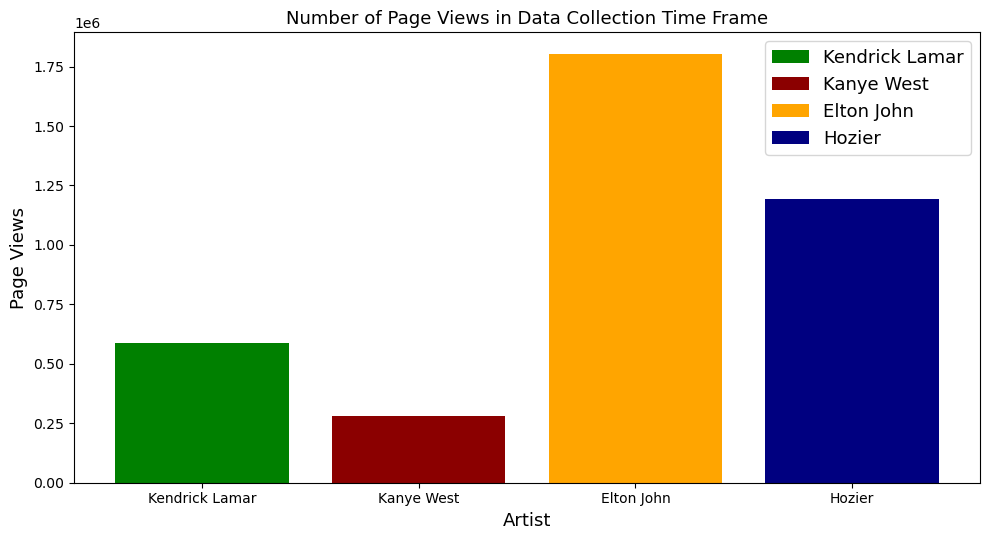

In [86]:
page_views = [None]*len(artist_files[artist_name])
fig = plt.figure(figsize=(10, 5.5))

for i,artist_name in enumerate(artist_names):
    most_views = 0
    x = 0

    #Find and plot the number of Page Views of the top song per artist
    for i in range(len(df_artists[artist_name]["Song Title"])):
        if df_artists[artist_name]["Song Title"][i] == song_names[artist_name]:
            page_views[x] = df_artists[artist_name]["Page Views"][i]
            x = x+1
     
    page_views_hundreds = [x - page_views[0] for x in page_views]
    plt.bar(artist_name,page_views_hundreds, color=artist_colours[artist_name])
    plt.legend(artist_names, fontsize=fontsize)
    
plt.xlabel("Artist", fontsize=fontsize)
plt.ylabel("Page Views", fontsize=fontsize)
plt.title("Number of Page Views in Data Collection Time Frame", fontsize=fontsize)
    
fig.tight_layout()


This plot further highlights the amount of Page Views received by each artist in the data collection time frame. The amount received by Elton becomes far more obvious.

## User Interest Analysis

Analyse the amount of 'pyongs' a song has on Genius to give an indication of user interest.

In [87]:
df_interest_stats = compute_stats("User Interest")
df_interest_stats

,Min,Max,Mean,Median
Artist,,,,
Kendrick Lamar,112,2239,942.20,703.5
Kanye West,189,452,333.57,365.0
Elton John,3,60,25.91,23.0
Hozier,5,1603,208.87,49.0


Plot these stats on a single bar chart.

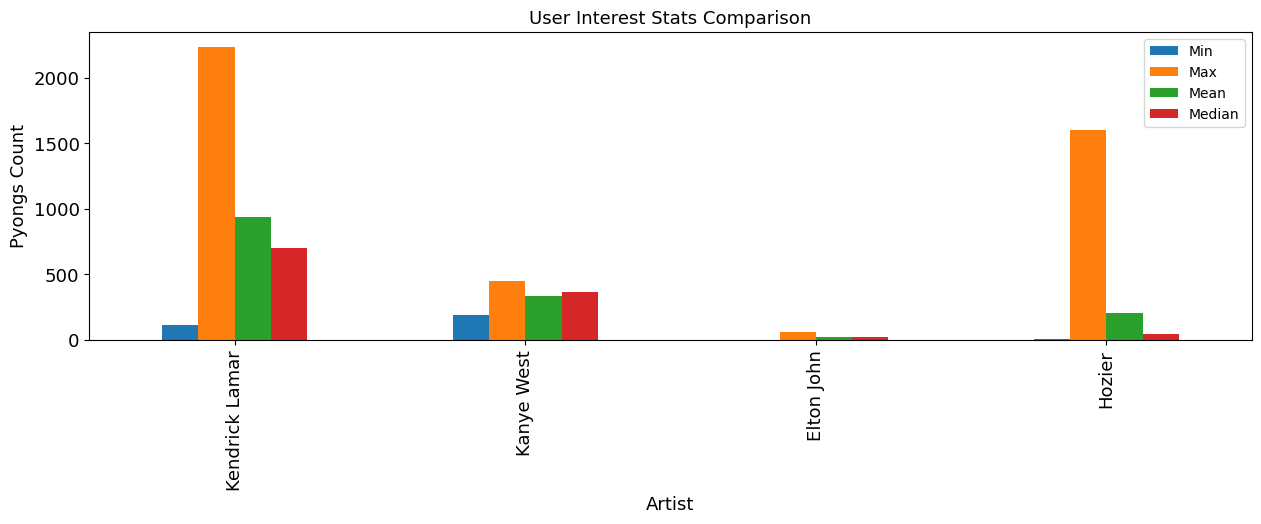

In [88]:
ax = df_interest_stats.plot.bar(figsize=(15, 4), fontsize=fontsize)

ax.set_title("User Interest Stats Comparison", fontsize=fontsize)
ax.set_xlabel("Artist", fontsize=fontsize)
ax.set_ylabel("Pyongs Count", fontsize=fontsize);


The general stats for the User Interest are visulaised on the above plot. It is evident that the interest in certain artist's is far greater than others. Kendrick, for example, is attributed a minimum value which is greater than any of Elton's statistics. User interest can be seen to depend on the song more than the artist in some cases however. Hozier for example has a maximum value which is over a thousand 'pyong' units larger than his minimum value. 

Use a boxplot for more analysis of the distribution for User Interest.

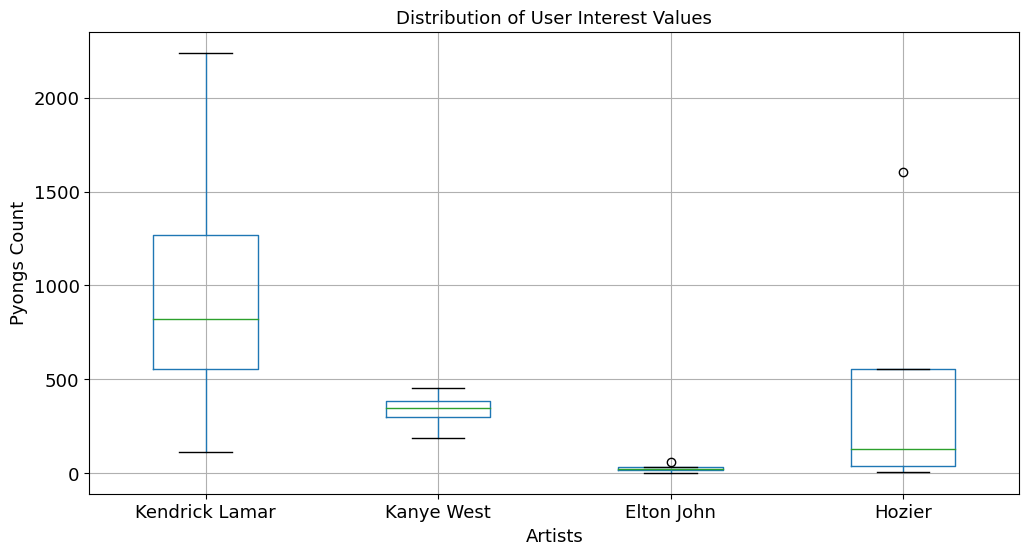

In [92]:
ax = df_interest_stats.transpose().boxplot(figsize=(12,6), fontsize=fontsize)

# Set axis labels and title
ax.set_ylabel("Pyongs Count", fontsize=fontsize)
ax.set_xlabel("Artists", fontsize=fontsize)
ax.set_title("Distribution of User Interest Values", fontsize=fontsize)

# Customize boxplot colors
for patch in ax.artists:
    # Change the facecolor of each patch (which is the box)
    patch.set_facecolor('blue')

    # Change the edgecolor of each patch (optional)
    patch.set_edgecolor('blue')

Again, the box plots  show the median values and also provide a clear view of the variation in the annotations for each artist.

Find the user interest for each song and store them according to each artist.


In [93]:
interest_per_song = []
interest_per_artist = {}

for artist_name in artist_names:
    interest_per_song.append(df_artists[artist_name]["User Interest"].head(first_ten_songs))
    for x in range(len(interest_per_song)):
        interest_per_artist[artist_name] = interest_per_song[x]
        

Plot the user interst on pie charts, categorising them at different threshold values. Due to the vast differences in the magnitude of User Interest count it is necessary to alter the categories on the pie charts. In order for the pie chart visualisation to be effective, the different categories are altered per artist, depending on the artist's mean User Interest value.

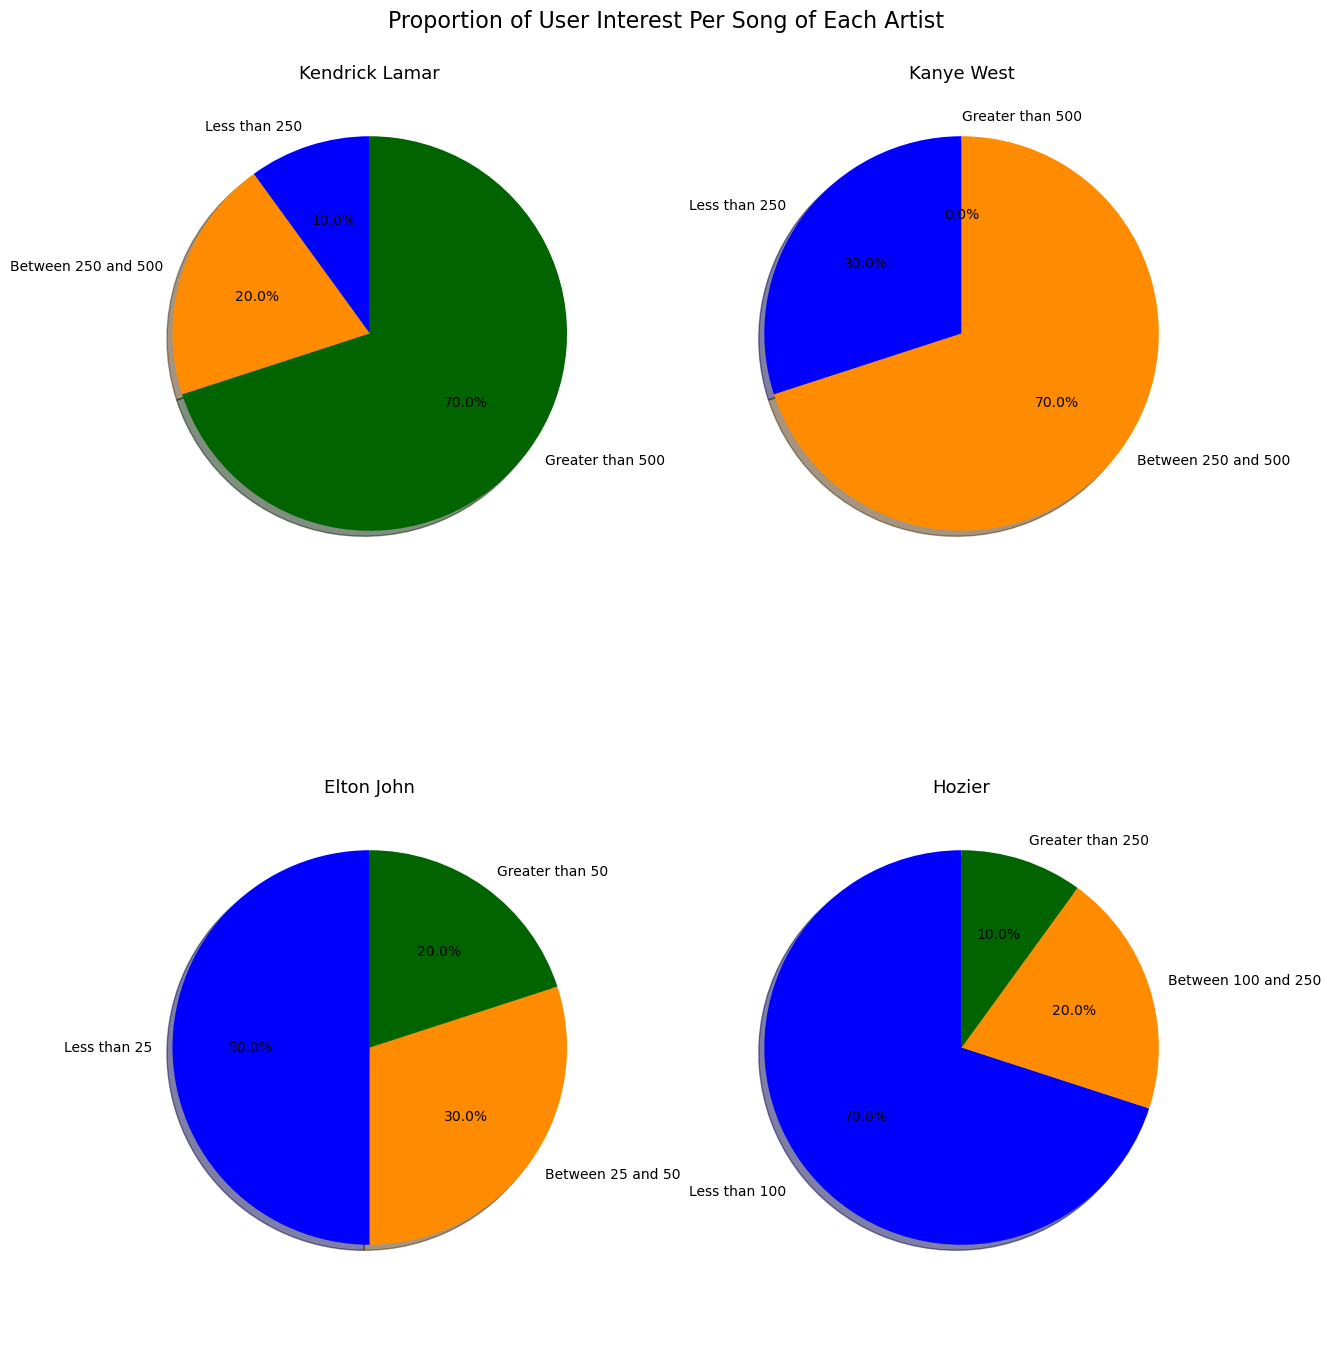

In [94]:
count1 = {}
count2 = {}
count3 = {}
count = {}

fig = plt.figure(figsize=(14, 17))
plt.title("Proportion of User Interest Per Song of Each Artist", fontsize=fontsize+3)
plt.axis("Off")
categories = ["Over 10", "Over 50", "Over 100"]

#initialise with just keys
for artist_name in artist_names:
    count1[artist_name] = 0
    count2[artist_name] = 0
    count3[artist_name] = 0

for i,artist_name in enumerate(artist_names):
    ax = fig.add_subplot(2, 2, i+1)
    for song in interest_per_artist[artist_name]:
        # Check the mean value for user interest for the artist 
        if df_interest_stats['Mean'][artist_name] < 100:
            # Create the categories and the count values for those categories
            categories = ["Less than 25", "Between 25 and 50", "Greater than 50"]
            if song > 0 and song < 25:
                count1[artist_name] = count1[artist_name] + 1
            if song > 25 and song < 50:
                count2[artist_name] = count2[artist_name] + 1
            if song > 50:
                count3[artist_name] = count3[artist_name] + 1
                
        if df_interest_stats['Mean'][artist_name]  > 100 and df_interest_stats['Mean'][artist_name] < 250:
            categories = ["\n\nLess than 100", "Between 100 and 250", "Greater than 250"]
            if song < 100:
                count1[artist_name] = count1[artist_name] + 1
            if song > 100 and song < 250:
                count2[artist_name] = count2[artist_name] + 1
            if song > 250:
                count3[artist_name] = count3[artist_name] + 1
                
        if df_interest_stats['Mean'][artist_name]  > 250:
            categories = ["Less than 250", "Between 250 and 500", "Greater than 500"]
            if song < 250:
                count1[artist_name] = count1[artist_name] + 1
            if song > 250 and song < 500:
                count2[artist_name] = count2[artist_name] + 1
            if song > 500:
                count3[artist_name] = count3[artist_name] + 1

            
    count[artist_name] = [count1[artist_name], count2[artist_name], count3[artist_name]]
    
    ax.pie(count[artist_name], labels=categories, colors=["Blue","darkorange","darkgreen","purple"],
           autopct="%.1f%%", shadow=True, startangle=90)
    ax.set_title("%s" % artist_name, fontsize=fontsize)

    

The pie charts provide further insight into the User Interest of each artist and help further identify whether User Interst statistics rely more on the artist or the songs.

# Lyric Analysis

Briefly summarise and visulaise the Lyric stats for each song. 

(The main purpose of obtaining the Lyric data is for investigation of correlations between the number of lyrics and the interation with the song, through annotations, page views etc.)

In [95]:
df_lyric_stats = compute_stats("Lyrics")
df_lyric_stats

,Min,Max,Mean,Median
Artist,,,,
Kendrick Lamar,0.0,823.0,184.00,0.0
Kanye West,0.0,348.0,31.64,0.0
Elton John,0.0,310.0,42.55,0.0
Hozier,0.0,265.0,41.50,0.0


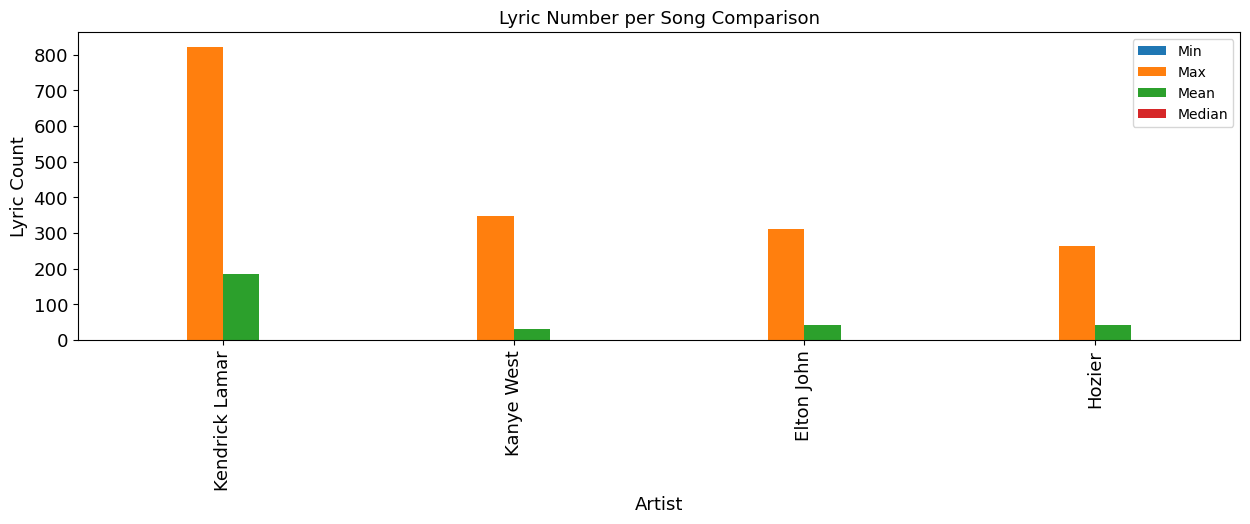

In [96]:
ax = df_lyric_stats.plot.bar(figsize=(15, 4), fontsize=fontsize)

ax.set_title("Lyric Number per Song Comparison", fontsize=fontsize)
ax.set_xlabel("Artist", fontsize=fontsize)
ax.set_ylabel("Lyric Count", fontsize=fontsize);


# Correlations

Investigate the correlation between different variable values in the data collected.

Create a function which used to plot a heat map

In [97]:
import numpy as np
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(24, 12, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)
    

Plotting a scatter matrix to look at the relationship between the values of interest.

Text(0.5, 0.98, 'Scatter Matrix of correlation between different variables')

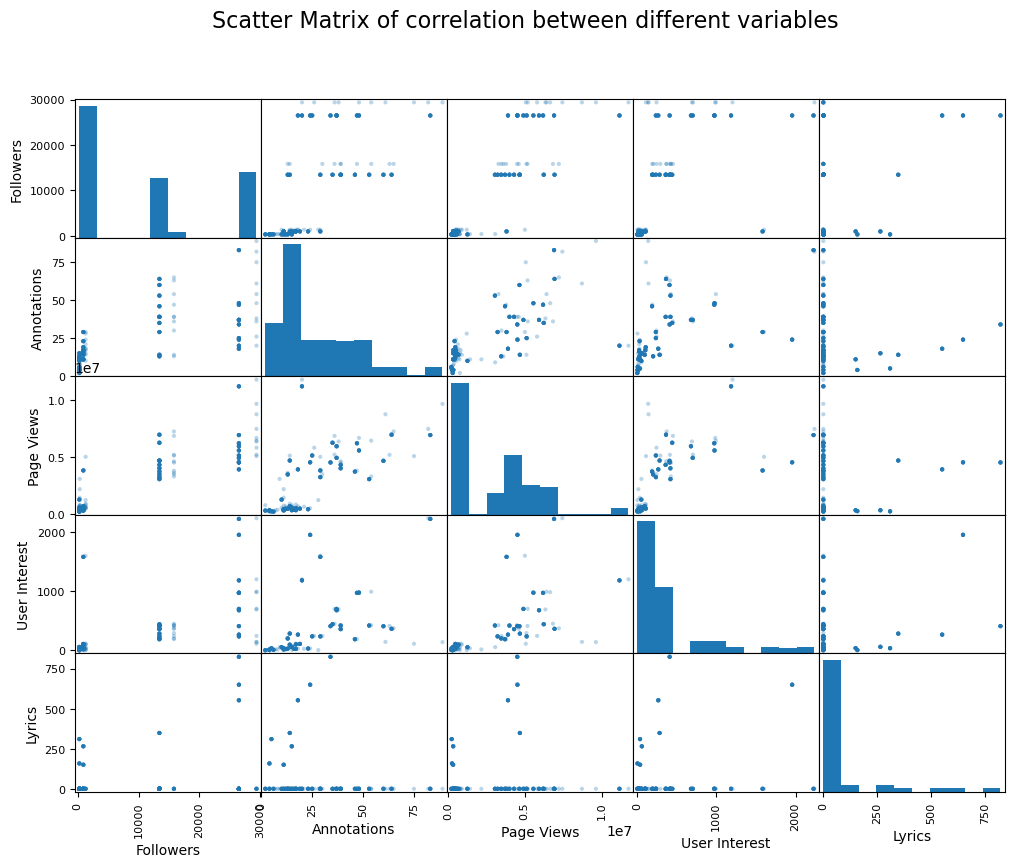

In [103]:
# Initialize an empty list to store the DataFrames
dfs = []

for artist_name in artist_names:
    # Filter the numeric values from each artist in the artist DataFrame
    values = df_artists[artist_name].filter(['Followers', 'Annotations', 'Page Views', 'User Interest', 'Lyrics'], axis=1)
    # Append the filtered DataFrame to the list
    dfs.append(values)

# Concatenate all the DataFrames in the list into a single DataFrame
df_numeric_values = pd.concat(dfs, ignore_index=True)

# Plot the scatter matrix
ax = scatter_matrix(df_numeric_values, figsize=(12, 9), alpha=0.3)
plt.suptitle("Scatter Matrix of correlation between different variables", fontsize=fontsize+3)

Look at the correlation heatmap for these numeric values.

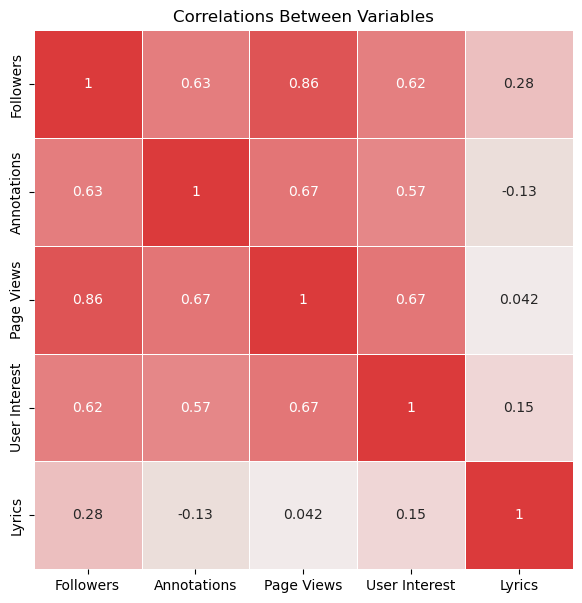

In [104]:
plot_heatmap("Correlations Between Variables", df_numeric_values, figsize=(11,7))

As we may expect, the correlations between the variables are all positive, none of which are particularly weak, however some insight can still be gained as to which variables generate more of another variable. For example, the number of lyrics in a song correlates to the number of annotations with an R value of 0.86, indicating a strong correlation and and increase in the number of annotations, depending on the number of lyrics in a song. 

Also, the number of page views has a strong correlation to the number of lyrics in a song, indicating an increase in the song lyrics will increase the amount of times the page on Genius is searched. 

# Conclusion

In this assignment I looked at the data for different artist's over the period of an hour and a half, provided by Genius, with a focus on: Annotations, Page Views and User Interest. It was found that some artist's had more interaction on the Genius website than others overall, while some had more interaction than others over the data collection time frame. As well as this the data provided by the API seemed to all correlate positively with each other, as they are based around user interaction. 

A challenge encountered in this analysis was the stagnant nature of the data on the Genius API. Most of the data does not change radically, or at all over a short period of time, creating many repeated values in the collected and stored data, while some (Page Views) are constantly changing and increasing. A lot of preprocessing was also required in order to merge raw data into a single dataset for each artist. 

For further investigation and analysis of data the following could be considered:

1. If the genre, age or location of each song or artist was available, data about the interaction with these could display what type of music is most popular on the website and in general.

2. With more data over a longer period of time, an attempt to find the number of lyrics which optimises the Page Views or User Interest of a song. 

3. The analysis could be extended to a larger time frame to investige the fluctuations in interaction (particularly Pave Views) depending on time's in different countries, and an attempt to map the popularity of an artist in different geographical regions could be made.